In [64]:
import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import uniform, randint

from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator

from mlens.ensemble import SuperLearner

sns.set()
sns.set_style('white') 
sns.set_color_codes(palette='pastel')

#plt.rcParams['axes.unicode_minus'] = False
#path = 'C:/Windows/Fonts/malgun.ttf'
#font_name = mpl.font_manager.FontProperties(fname=path, size=50).get_name()
#print(font_name)
#plt.rc('font', family=font_name)

In [65]:
np.random.seed(2017020558)

In [66]:
root_dir = 'Z:/3. 개인백업/이민정/한화교육준비/Data/'
os.chdir(root_dir)
data = pd.read_csv('preprocessed_kc_house_data.csv')

In [67]:
data.head()

Unnamed: 0      lat     long  bedrooms  bathrooms  floors  waterfront  \
0           0  47.6747 -122.303         4       2.25     2.0           1   
1           1  47.6914 -122.308         2       1.75     1.0           1   
2           2  47.5951 -122.144         5       2.00     1.5           1   
3           3  47.3273 -122.370         3       2.00     1.0           1   
4           4  47.3584 -122.163         5       3.00     2.0           1   

   grade  condition  sqft_living  sqft_lot  sqft_above  sqft_basement  \
0      8          5         3750      5000        2440           1310   
1      6          3         1390      6670         720            670   
2      7          3         1870      7344        1870              0   
3      7          4         1410     44866        1410              0   
4      9          3         3223      6371        3223              0   

   yr_built  yr_renovated  year_2014  quarter_0  quarter_1  quarter_2    price  
0        94             0          0          0          1          0  1310000  
1        77             0          0          0          1          0   445500  
2        58             0          0          0          1          0   450000  
3        33             0          0          0          1          0   335000  
4         4             0          0          0          1          0   479349

In [68]:
data = data.drop(['Unnamed: 0'], axis=1)

In [69]:
y = data.price
X = data.drop(['price'], axis=1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=2017020558)

In [71]:
# 모델 초기화
el = ElasticNet(normalize=True)
dt = DecisionTreeRegressor(criterion='mse', random_state=2017020558)
rf = RandomForestRegressor(criterion='mse', random_state=2017020558)
gb = GradientBoostingRegressor(criterion='friedman_mse', random_state=2017020558)

In [72]:
base_learners = [('el', el), ('dt', dt), ('rf', rf), ('gb', gb)]

In [73]:
base_results = np.zeros((X_test.shape[0], len(base_learners)))
base_results = pd.DataFrame(base_results, columns=[e for e, _ in base_learners])

for est_name, est in base_learners:
    est.fit(X_train, y_train)
    pred = est.predict(X_test)
    base_results.loc[:, est_name] = pred
    print("%3s (%3s) : %.4f" % (est_name, 'MAE', mean_absolute_error(y_test, pred)))
    print("%3s (%3s) : %.4f" % (est_name, 'MSE', mean_squared_error(y_test, pred)))
    print('------------------------------------------------------')

 el (MAE) : 231338.3711
 el (MSE) : 125943044496.3869
------------------------------------------------------
 dt (MAE) : 102774.9495
 dt (MSE) : 34272022309.3931
------------------------------------------------------
 rf (MAE) : 74541.8450
 rf (MSE) : 17936686875.4552
------------------------------------------------------
 gb (MAE) : 80145.2014
 gb (MSE) : 18912737570.3001
------------------------------------------------------


In [74]:
param_dicts= {
    'el':{'alpha': uniform(1e-6, 1e-5),
         'l1_ratio': uniform(0, 1)},
    'dt':{'max_depth': randint(2, 5),
         'min_samples_split': randint(5,50)},
    'rf':{'max_depth': randint(2, 5),
         'n_estimators': randint(50,100)},
    'gb':{'learning_rate': uniform(0.02, 0.04),
         'max_depth': randint(3, 7),
         'n_estimators': randint(50,100)}
}

In [80]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

evl = Evaluator(
    scorer,
    cv=2,
    random_state=2017020558
)

In [81]:
evl.fit(
    X_train, y_train,
    estimators=base_learners,
    param_dicts=param_dicts,
    preprocessing={'sc': [StandardScaler()], 'none': []},
    n_iter=5 # bump this up to do a larger grid search
)

In [82]:
pd.DataFrame(evl.results)

test_score-m  test_score-s  train_score-m  train_score-s  \
none.dt -128652.219229   4722.570025 -121967.736893    1650.516767   
none.el -129546.188003   3264.866381 -129026.936445    4065.471295   
none.gb  -77575.315146   2269.625735  -58341.454215    1998.402195   
none.rf -113148.102338   4994.049908 -108989.580211    2229.142075   
sc.dt   -128638.521223   4736.268031 -121967.736893    1650.516767   
sc.el   -129546.188003   3264.866381 -129026.936445    4065.471295   
sc.gb    -77598.572244   2282.434861  -58341.454215    1998.402195   
sc.rf   -113145.875313   4995.054776 -108990.323734    2227.586436   

         fit_time-m  fit_time-s  pred_time-m  pred_time-s  \
none.dt    0.021532    0.000050     0.002205     0.000733   
none.el    1.173995    0.001549     0.000543     0.000055   
none.gb    1.868455    0.030327     0.018176     0.000200   
none.rf    0.899795    0.032929     0.017860     0.000304   
sc.dt      0.017735    0.000663     0.000619     0.000003   
sc.el      0.510078    0.091331     0.000407     0.000043   
sc.gb      1.770163    0.000899     0.016103     0.000441   
sc.rf      0.829419    0.034143     0.015492     0.000482   

                                                    params  
none.dt          {'max_depth': 4, 'min_samples_split': 20}  
none.el  {'alpha': 5.327881589475289e-06, 'l1_ratio': 0...  
none.gb  {'learning_rate': 0.04880968055080473, 'max_de...  
none.rf               {'max_depth': 4, 'n_estimators': 76}  
sc.dt            {'max_depth': 4, 'min_samples_split': 20}  
sc.el    {'alpha': 5.327881589475289e-06, 'l1_ratio': 0...  
sc.gb    {'learning_rate': 0.04880968055080473, 'max_de...  
sc.rf                 {'max_depth': 4, 'n_estimators': 76}

In [83]:
evl.results['params']['none.gb']

{'learning_rate': 0.04880968055080473, 'max_depth': 6, 'n_estimators': 76}

In [95]:
best_learner = base_learners[3][1]
best_learner.set_params(**evl.results['params']['none.gb'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.04880968055080473, loss='ls', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=76, presort='auto',
             random_state=2017020558, subsample=1.0, verbose=0,
             warm_start=False)

In [96]:
best_learner.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.04880968055080473, loss='ls', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=76, presort='auto',
             random_state=2017020558, subsample=1.0, verbose=0,
             warm_start=False)

In [99]:
y_train_pred = best_learner.predict(X_train)
y_test_pred = best_learner.predict(X_test)
print('- MSE (Train)      : {:.4f}'.format(mean_squared_error(y_train, y_train_pred)))
print('- MSE (Test) : {:.4f}'.format(mean_squared_error(y_test, y_test_pred)))

print('- MAE (Train)      : {:.4f}'.format(mean_absolute_error(y_train, y_train_pred)))
print('- MAE (Test) : {:.4f}'.format(mean_absolute_error(y_test, y_test_pred)))

print('- R square (Train)      : {:.4f}'.format(r2_score(y_train, y_train_pred)))
print('- R square (Test) : {:.4f}'.format(r2_score(y_test, y_test_pred)))

- MSE (Train)      : 9150504817.6535
- MSE (Test) : 16678994042.4454
- MAE (Train)      : 62763.6357
- MAE (Test) : 74236.1350
- R square (Train)      : 0.9334
- R square (Test) : 0.8676


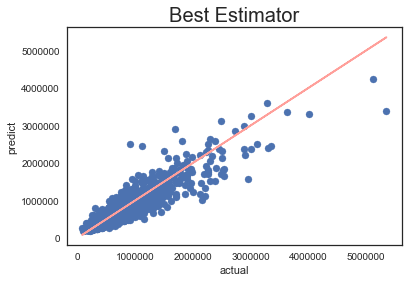

In [100]:
plt.scatter(y_test,y_test_pred)
plt.plot(y_test,y_test,'r')
plt.xlabel('actual')
plt.ylabel('predict')
plt.title('Best Estimator',fontsize=20)
plt.show()